
# CASE STUDY - topic modeling and feature engineering

In [1]:
import os
import re
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from string import punctuation, printable
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

try:
    import pyLDAvis
    import pyLDAvis.sklearn
except:
    raise Exception("'pip install pyldavis' before running this notebook")

pyLDAvis.enable_notebook()    
plt.style.use('seaborn')
%matplotlib inline




  
## Outline

1. EDA - summary tables, use tSNE to visualize the data
2. Create a transfomation pipelines for NMF and LDA
3. Use ldaviz and wordclouds to get insight into the clusters

## Data

Even before receiving the first comment, we want to start building our Pipeline using a proxy dataset. In this study Case we will work with a dataset publicly available dataset of movie reviews.

* [Here](http://www.nltk.org/nltk_data) is the web page that references all the public dataset that NLTK provide. In this Study Case we will work with the 'Sentiment Polarity Dataset Version 2.0' dataset. (The dataset has already been downloaded and is in the data folder of the working directory)
* For more examples of applications with these data see [NLTK's book chapter that uses these data](https://www.nltk.org/book/ch06.html)

In [2]:
DATA_DIR = os.path.join("D:\\data_science\\Topic-Modeling-Case-Study-Local","data")
movie_reviews = load_files(os.path.join(DATA_DIR, "movie_reviews"), shuffle=True)
X = movie_reviews.data
y = movie_reviews.target
target_names = movie_reviews.target_names
print(X[4])

b"kolya is one of the richest films i've seen in some time . \nzdenek sverak plays a confirmed old bachelor ( who's likely to remain so ) , who finds his life as a czech cellist increasingly impacted by the five-year old boy that he's taking care of . \nthough it ends rather abruptly-- and i'm whining , 'cause i wanted to spend more time with these characters-- the acting , writing , and production values are as high as , if not higher than , comparable american dramas . \nthis father-and-son delight-- sverak also wrote the script , while his son , jan , directed-- won a golden globe for best foreign language film and , a couple days after i saw it , walked away an oscar . \nin czech and russian , with english subtitles . \n"


In [3]:
len(X)

2000

The main focus of this exercise is to enable visualization of topics, but these topics can be used as additional 
features for prediction tasks.  
There are many ways to process tokens (words, dates, emojis etc).  NLTK is often used to pre-process text data before the tokens are vectorized.  Generally, the tokens are modified via [stemming or lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html).  The next code block provides a lemmatization function that makes use of the library [spacy](https://spacy.io/). 

In [4]:
import spacy
nlp = spacy.load("en_core_web_sm")
STOPLIST = ENGLISH_STOP_WORDS
STOPLIST = set(list(STOPLIST) + ["foo", "film", "movie", "make"])

#if not 'nlp' in locals():
#    print("Loading English Module...")
#    nlp = spacy.load('en_core_web_sm')

def lemmatize_document(doc, stop_words=None):
    """
    takes a list of strings where each string is a document
    returns a processed list of strings
    """
    
    if not stop_words:
        stop_words = set([])
  
    ## ensure working with string
    doc = str(doc)
    doc = doc.replace('\\n','')
    doc = doc.replace('\\t','')

    # First remove punctuation form string
    if sys.version_info.major == 3:
        PUNCT_DICT = {ord(punc): None for punc in punctuation}
        doc = doc.translate(PUNCT_DICT)

    # remove unicode
    clean_doc = "".join([char for char in doc if char in printable])
            
    # Run the doc through spaCy
    doc = nlp(clean_doc)

    # Lemmatize and lower text
    tokens = [re.sub(r"\W+","",token.lemma_.lower()) for token in doc ]
    tokens = [t for t in tokens if len(t) > 1]
    
    return ' '.join(w for w in tokens if w not in stop_words)    

## example usage
corpus = ['"You can fool some of the people all of the time, and all of the people some of the time, but you can not fool all of the people all of the time". -- Abraham Lincoln']
processed = [lemmatize_document(doc, STOPLIST) for doc in corpus]
print(processed[0])
processed = [lemmatize_document(doc, None) for doc in corpus]
print("\n"+processed[0])

C:\Users\XIAOMi\anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
C:\Users\XIAOMi\anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
C:\Users\XIAOMi\anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:43: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descripto

fool people time people time fool people time abraham lincoln

you can fool some of the people all of the time and all of the people some of the time but you can not fool all of the people all of the time abraham lincoln


In [5]:

## Preprocess all the reviews of the corpus with the lemmatize_document() 
## function to create a list of cleaned reviews.
processed = [lemmatize_document(doc, STOPLIST) for doc in X]
print("processing done.")

processing done.



Use the CountVectorizer from sklearn to vectorize the documents.


* [scikit-learn CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* [scikit-learn working with text](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

Because this is an exercise in visualization set the `max_features` to something like 500.  In the context of supervised learning it is reasonable to grid-search to optimize this parameter.

In [6]:
max_features = 500

# Create a CountVectorizer object
tf_vectorizer = CountVectorizer(max_features = 500)

# Fit and transform this object to the processed reviews
tf = tf_vectorizer.fit_transform(processed)
print("ready")

ready


### QUESTION 3

Fit a LDA model to the corpus. For example, you could use something like the following.

```python
n_topics = 10
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)

lda_model.fit(tf)
```


* [scikit-learn's LDA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
* [scikit-learn's user guide for LDA](https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation)

In [12]:
n_topics = 10

# Create an LDA object
lda_model =  LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)

lda_model.fit(tf)

# Fit the model to the bag of word we created earlier


LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

## QUESTION 4

Visualize the corpus using [pyldavis](https://github.com/bmabey/pyLDAvis).

```python
pyLDAvis.sklearn.prepare(lda_model,tf, tf_vectorizer, R=20)
```

* [PyLDAViz documentation](https://pyldavis.readthedocs.io/en/latest)
* [PyLDAViz demos](https://pyldavis.readthedocs.io/en/latest/readme.html#video-demos)

In [8]:
pyLDAvis.sklearn.prepare(lda_model,tf, tf_vectorizer, R=20)

C:\Users\XIAOMi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\XIAOMi\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.009242 -0.006040       1        1  23.320331
3      0.011683  0.032888       2        1  18.304027
1     -0.005631  0.005144       3        1  17.394559
5      0.018424  0.007995       4        1  11.648892
2     -0.048293  0.010763       5        1   6.873351
8     -0.009538  0.020690       6        1   6.359730
7     -0.067217  0.006136       7        1   4.755951
9      0.110834  0.103358       8        1   4.615900
6     -0.136146 -0.050004       9        1   4.140255
0      0.135127 -0.130931      10        1   2.587004, topic_info=       Term         Freq        Total Category  logprob  loglift
11    alien   628.000000   628.000000  Default  20.0000  20.0000
119  effect   820.000000   820.000000  Default  19.0000  19.0000
3    action  1207.000000  1207.000000  Default  18.0000  18.0000
411    star  1277.000000  1277.000000  Default  17.0000  17.0000
245    life  1667.000000  1667.000000  Default  16.0000  16.0000
..      ...          ...          ...      ...      ...      ...
249  little    98.946003  1483.818594  Topic10  -4.1686   0.9469
417   story    64.322486  2332.197692  Topic10  -4.5992   0.0640
445    time    64.782968  2815.327939  Topic10  -4.5921  -0.1171
176    good    55.131511  3436.953679  Topic10  -4.7534  -0.4779
499   young    49.943240   852.862469  Topic10  -4.8522   0.8170

[362 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
3         1  0.127577  action
3         2  0.109351  action
3         3  0.014912  action
3         4  0.028166  action
3         5  0.579893  action
...     ...       ...     ...
499       6  0.012898   young
499       7  0.024623   young
499       8  0.182913   young
499       9  0.035176   young
499      10  0.058626   young

[2055 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 6, 3, 9, 8, 10, 7, 1])


Try different numbers of clusters until there is decent separation in the visualization

In [14]:

# set the number of topics
n_topics = 7

# Create the LDA model
lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                      learning_method='online',
                                      learning_offset=50.,
                                      random_state=0)



# fit and transform the LDA model to the vecotrized corpus
lda_model.fit(tf)
lda_transformed = lda_model.transform(tf)
# use the pyLDAvis to visualise the topics
pyLDAvis.sklearn.prepare(lda_model,tf, tf_vectorizer, R=20)

C:\Users\XIAOMi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\XIAOMi\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.006744  0.008197       1        1  25.343476
3      0.007040 -0.008885       2        1  21.275162
1     -0.000901 -0.020445       3        1  19.868526
5      0.015411 -0.017301       4        1  13.568126
6     -0.113546 -0.036615       5        1   8.566542
2     -0.024834  0.088038       6        1   7.540443
0      0.123574 -0.012989       7        1   3.837725, topic_info=          Term         Freq        Total Category  logprob  loglift
11       alien   628.000000   628.000000  Default  20.0000  20.0000
3       action  1189.000000  1189.000000  Default  19.0000  19.0000
449       town   407.000000   407.000000  Default  18.0000  18.0000
222        joe   319.000000   319.000000  Default  17.0000  17.0000
119     effect   820.000000   820.000000  Default  16.0000  16.0000
..         ...          ...          ...      ...      ...      ...
364       role    75.028097  1147.049194   Topic7  -4.8397   0.5332
176       good   103.392289  3461.526957   Topic7  -4.5190  -0.2506
441      thing    78.043589  1631.099411   Topic7  -4.8002   0.2205
445       time    81.823886  2821.080326   Topic7  -4.7529  -0.2800
59   character    78.573137  3865.453573   Topic7  -4.7935  -0.6355

[279 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
3         1  0.187411  action
3         2  0.170603  action
3         3  0.011766  action
3         4  0.069754  action
3         5  0.163039  action
...     ...       ...     ...
499       3  0.174530   young
499       4  0.289697   young
499       5  0.042742   young
499       6  0.045117   young
499       7  0.034431   young

[1267 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 6, 7, 3, 1])

The visualization here can help determine a reasonable number of number of clusters and it can serve as a communication tool.  If the goal was to find topics that are associated with customer profiles then you would likely work with folks in marketing to refine the clustering.  There are a couple of parameters than can be used to modify the clustering and visualization.  The discovery of meaningful topics is a form of feature engineering.

## Top words

If you were to use the topics from this model to inform clustering or supervised learning you would first need to be able to extract and represent them as a matrix.  Along the same lines if you were to populate a report with tabular descriptions of the data then you will need to be able to extract topic representations.  Here is a starter function

In [15]:
def get_top_words(model, feature_names, n_top_words):
    """
    Get the top words defining the different topics of the LDA model
    INPUT : the LDA model, the names of the features of the bag of word (these are the actual words in the vocabulary) 
    and the number of top words.
    RETURN : A dictionary where the keys are the topic's ID and the values are the lists of the n_top_words top words.
    
    """
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        _top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words[str(topic_idx)] = _top_words
    return top_words

Use the function to print the top k words for each topic

In [17]:

## set n_top_words
top_words = 15

## get the vectorizer's feature names
tf_feature_names = tf_vectorizer.get_feature_names()

## get the top words for each topic
top_words = get_top_words(lda_model, tf_feature_names, top_words)

## print the topics and the top words of each topic


In [18]:
print(top_words)

{'0': ['town', 'joe', 'kevin', 'smith', 'wild', 'performance', 'mother', 'drug', 'play', 'good', 'small', 'life', 'come', 'dream', 'daughter'], '1': ['just', 'like', 'character', 'know', 'scene', 'time', 'say', 'story', 'people', 'good', 'really', 'thing', 'think', 'come', 'life'], '2': ['action', 'scene', 'disney', 'jackie', 'like', 'good', 'vampire', 'time', 'voice', 'plot', 'story', 'mr', 'character', 'van', 'look'], '3': ['character', 'story', 'good', 'time', 'life', 'play', 'scene', 'like', 'new', 'work', 'performance', 'great', 'world', 'role', 'way'], '4': ['like', 'good', 'bad', 'just', 'character', 'play', 'time', 'comedy', 'funny', 'really', 'think', 'thing', 'look', 'scene', 'big'], '5': ['man', 'like', 'love', 'family', 'good', 'scene', 'time', 'character', 'way', 'life', 'year', 'play', 'child', 'come', 'young'], '6': ['alien', 'star', 'effect', 'like', 'series', 'special', 'good', 'ship', 'planet', 'earth', 'time', 'human', 'just', 'plot', 'space']}


## PCA& TSNE

If you used `transform` on your original tokens you should have a `2000 x k` array where `k` is the number of topics you choose.  Create a PCA or tSNE visualization that projects this matrix into lower dimensional space then uses colors to indicate which documents belong to a topic (e.g. probability > 0.5).

C:\Users\XIAOMi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\XIAOMi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


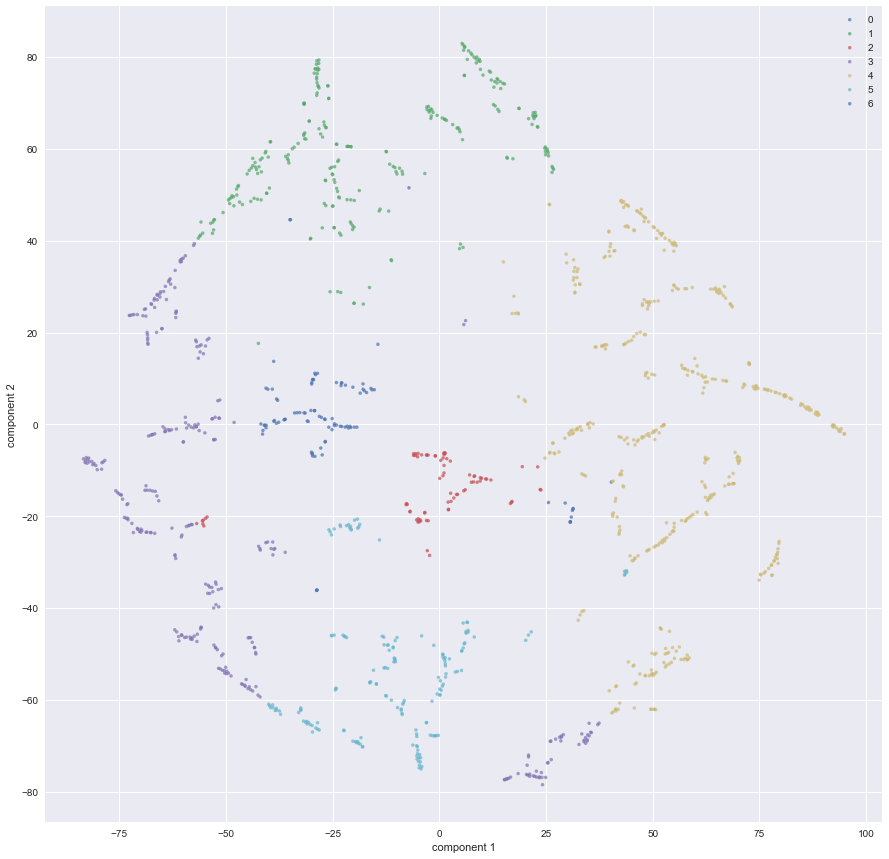

In [19]:
## YOUR CODE HERE
def make_plot(lda_mat):
    
    fig = plt.figure(figsize=(15,15), facecolor='white')
    ax = fig.add_subplot(111)
    
    tsne = TSNE(n_components=2, perplexity=10, init='pca')
    projected = tsne.fit_transform(lda_mat)
    
#     pca = PCA(n_components=2)
#     projected = pca.fit_transform(lda_mat)
    
    for class_num in np.arange(n_topics):
        topic_inds = np.where(lda_mat[:, class_num] > 0.5)[0]
        ax.scatter(projected[topic_inds, 0],
                   projected[topic_inds, 1], 
                   edgecolor='none', marker='.', alpha=0.7, label=str(class_num))

    ax.set_xlabel('component 1')
    ax.set_ylabel('component 2')
    ax.legend()
    
    
make_plot(lda_transformed)